In [1]:
# system stuff
import sys
sys.path.append("..")
import datetime

# galpy stuff
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel
from galpy.actionAngle import UnboundError

# auriga stuff
from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

# main packages stuff
import numpy as np
from scipy import stats

# python stuff
import random
import copy

# plot stuff
from IPython.display import Image, display
import corner

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
from matplotlib import animation
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib import rcParams
from matplotlib import colors

%matplotlib inline

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['image.cmap'] = 'magma'
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.format'] = 'png'
cmap = copy.copy(plt.cm.get_cmap(rcParams['image.cmap']))
cmap.set_bad((0,0,0))

# display stuff
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [2]:
machine = 'virgo'
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
elif machine == 'virgo': 
    basedir = "/virgo/simulations/Auriga/level4_MHD/"
    filedir = "/u/milas/masterthesis/masterproject/files/"
    plotdir = "/u/milas/masterthesis/masterproject/plots/"
    


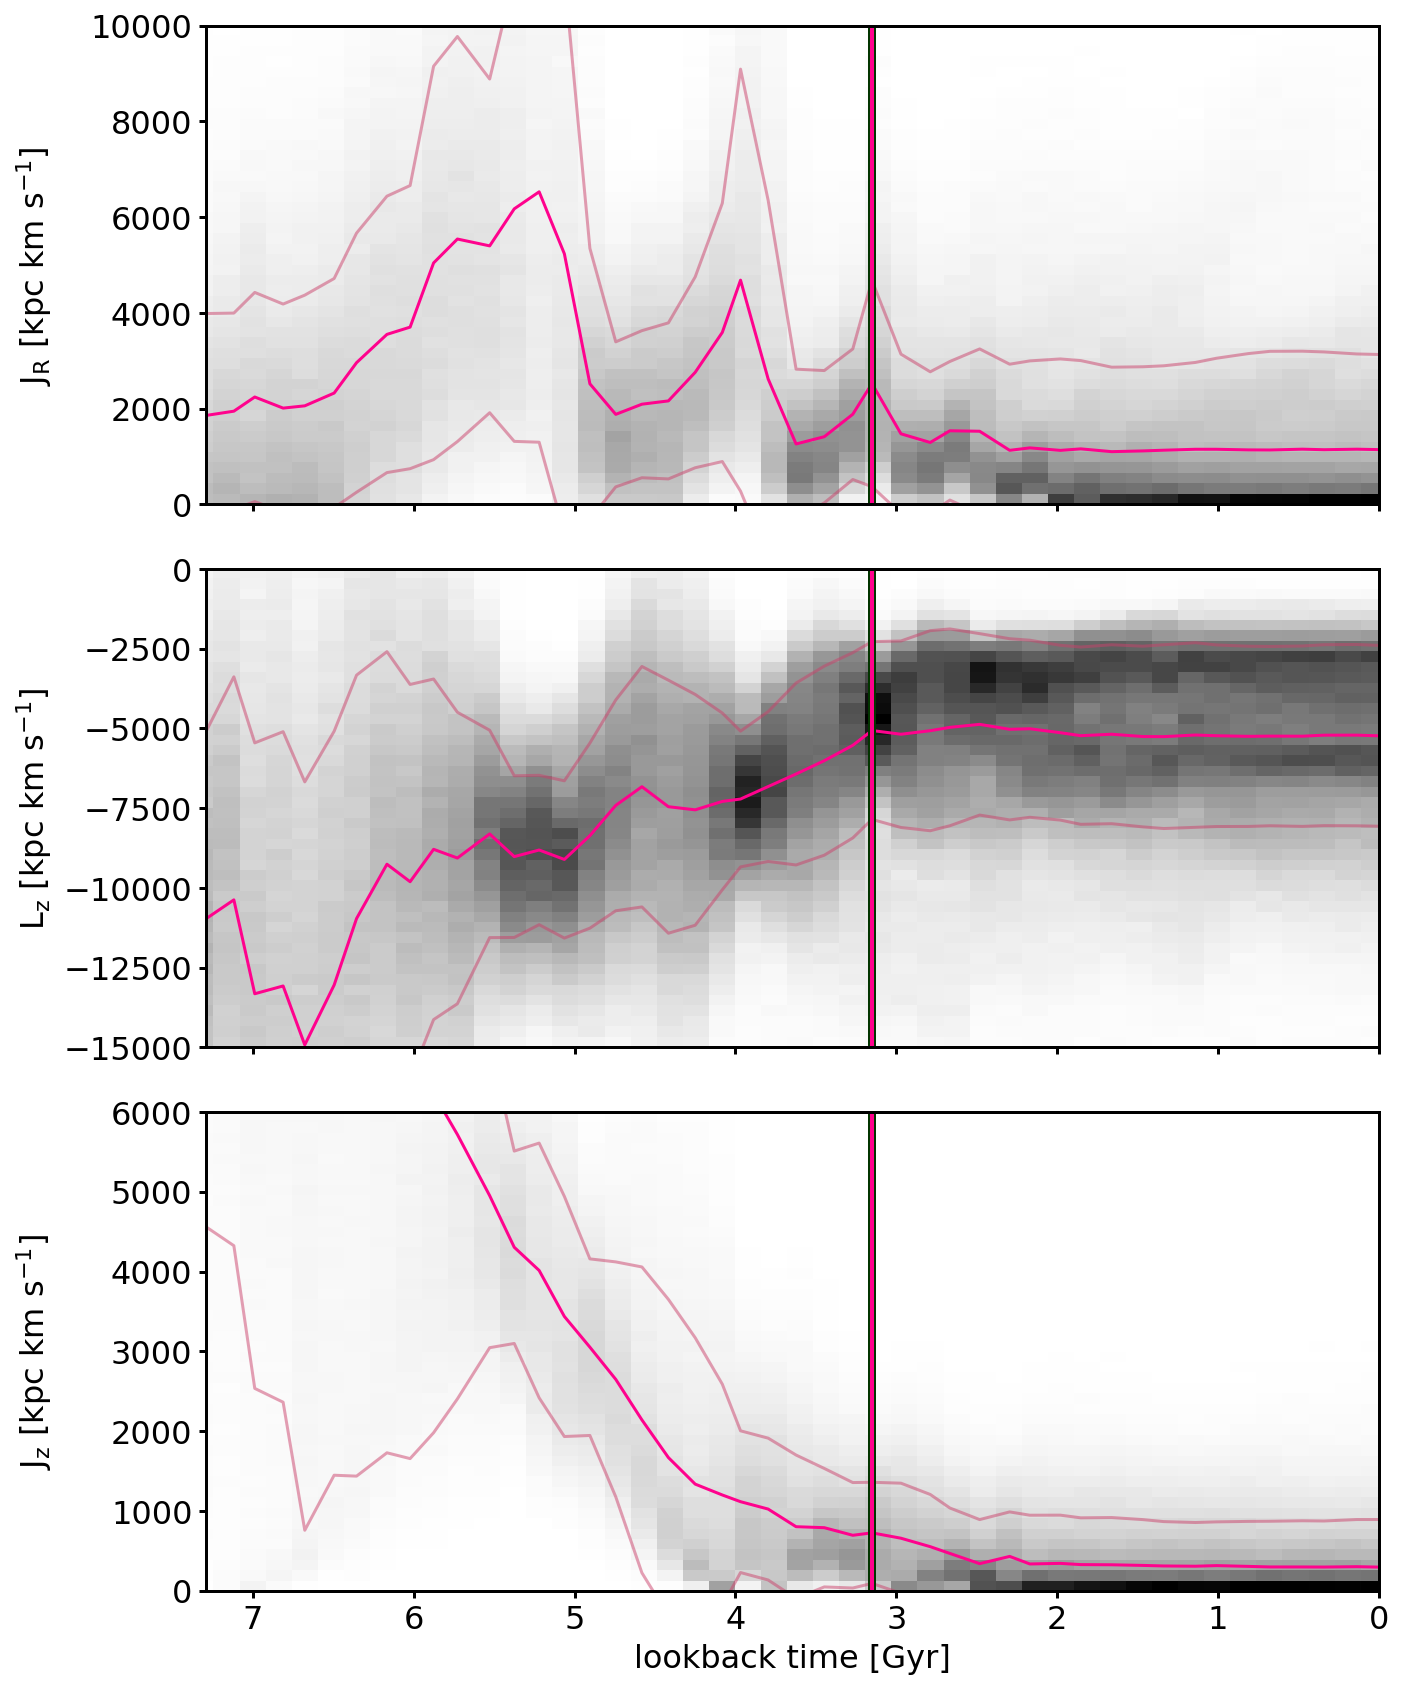

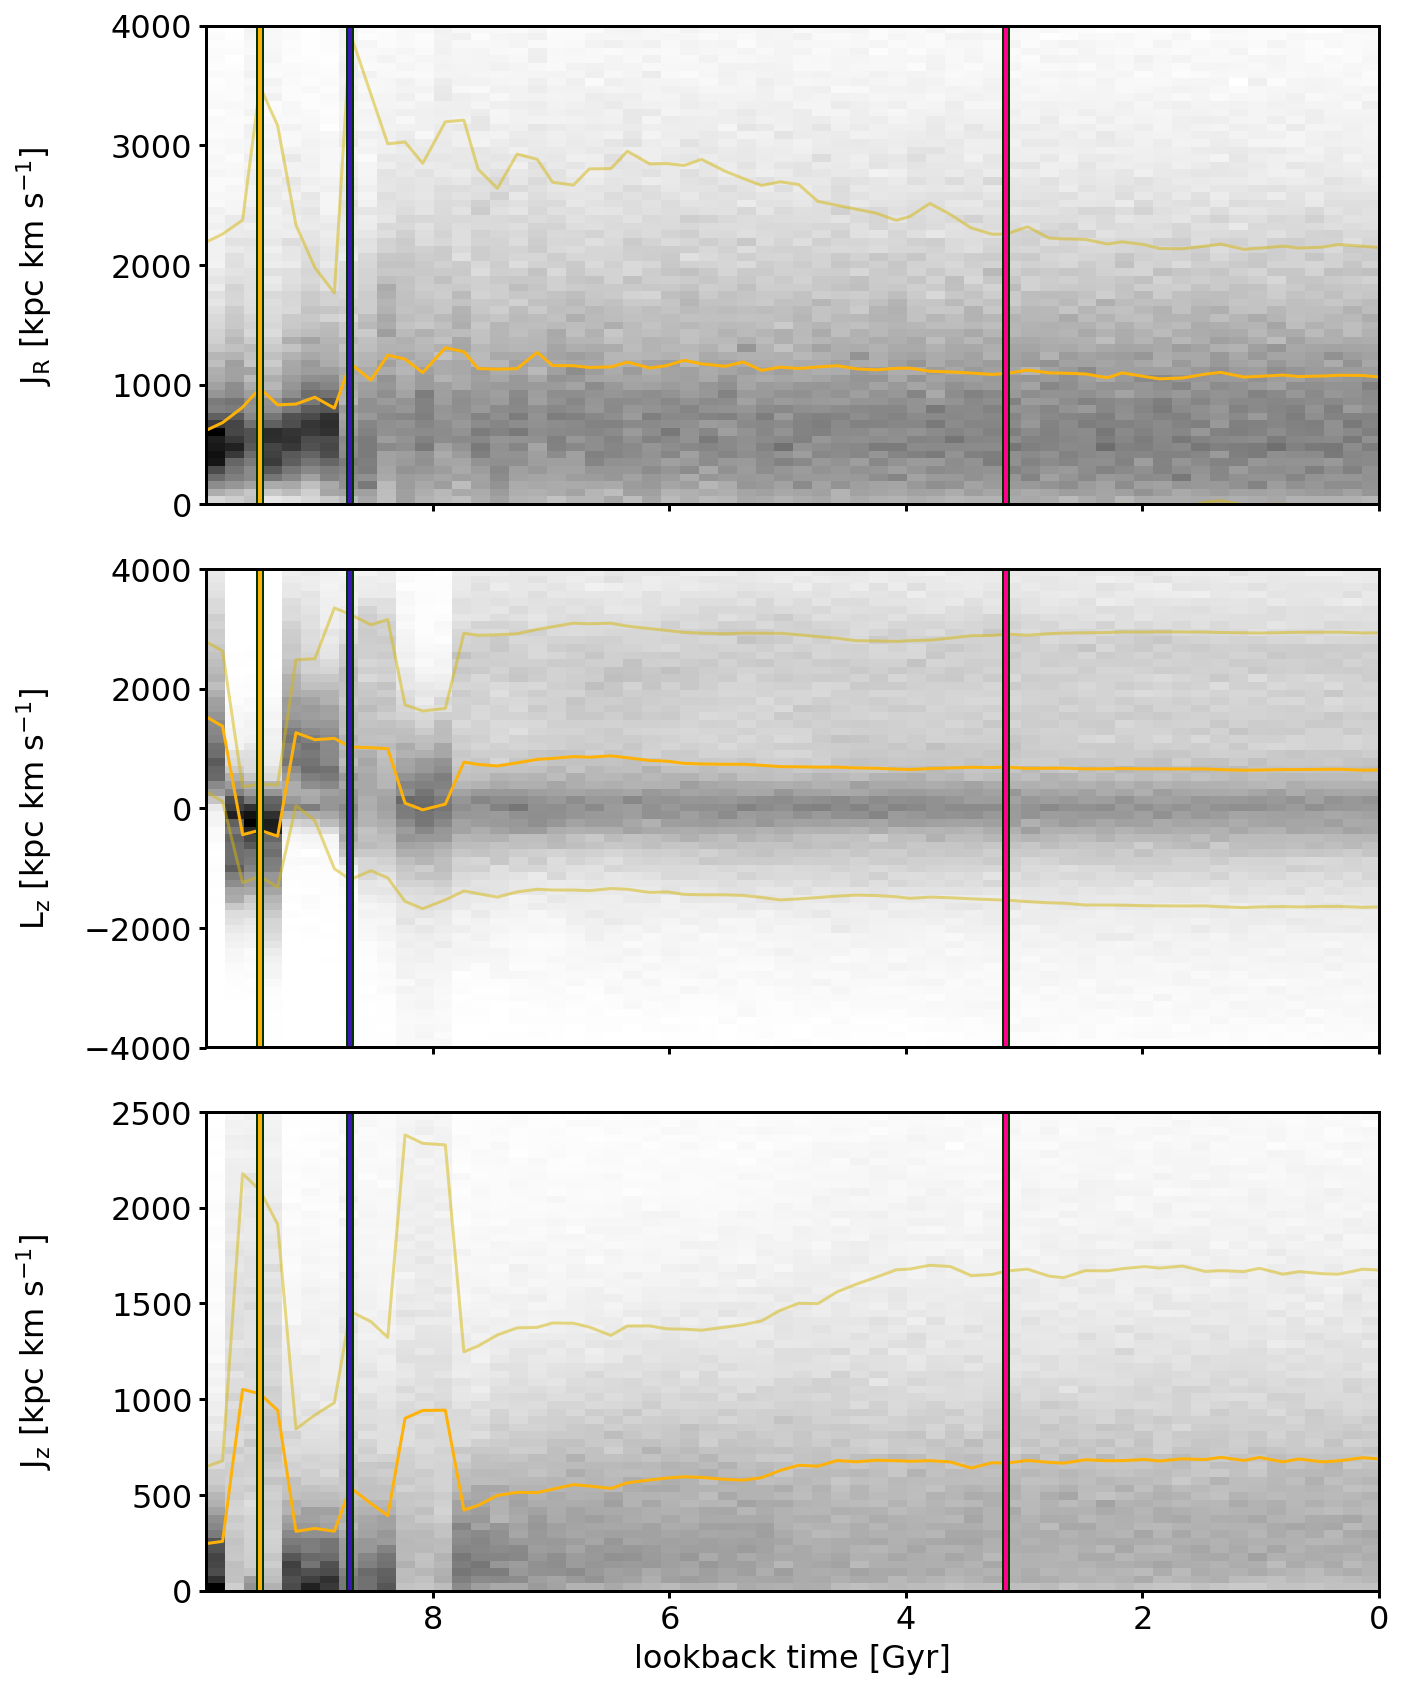

In [6]:
halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"
level = 4

colors = ['black', 'black', 'xkcd:hot pink', 'xkcd:indigo blue', 'xkcd:saffron']
colors2 = ['black', 'black', 'xkcd:pink', 'xkcd:blue', 'xkcd:yellow']
colors2 = ['black', 'black', 'xkcd:dark pink', 'xkcd:dark blue', 'xkcd:dark yellow']

color11 = colors[2]
color12 = 'xkcd:pink'
color13 = 'xkcd:dark pink'
color21 = colors[3]
color22 = 'xkcd:blue'
color23 = 'xkcd:dark blue'
color31 = colors[4]
color32 = 'xkcd:yellow'
color33 = 'xkcd:dark yellow'

prognums = [2,4] #3 later once it finishes
for i, prognum in enumerate(prognums):
    #### action time evolution
    if prognum == 4:
        startnr = 65
    elif prognum == 3:
        startnr = 70
    elif prognum == 2:
        startnr = 82
    endnr = 127
    numsnaps =endnr - startnr +1
    xrange = np.arange(startnr, endnr, 1)
    lookback_time_Gyr = []
    jR_median = []
    jR_std = []
    jz_median = []
    jz_std = []
    lz_median = []
    lz_std = []
    jR_all = []
    jz_all = []
    lz_all = []
    hist_x = []
    histtime_x = []
    lookback_time_Gyr = np.loadtxt(filedir + 'auriga/survivor_overview_all_snapshots.txt',usecols = 1, skiprows=2)[-numsnaps:]
    for snap_number in range(startnr, endnr+1, 1):
        ii = snap_number-startnr
        infile = filedir + 'actions/right_potential/progenitor{}/GCwodisk_actions_snap_{}_jan19.txt'.format(prognum, snap_number)
        ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)
        snap_time = lookback_time_Gyr[ii]

        jR_hist = np.histogram(jR_kpckms, bins = 20, range = (0., 10000.))
        jz_hist = np.histogram(jz_kpckms, bins = 20, range = (0., 5000.))
        lz_hist = np.histogram(lz_kpckms, bins = 20, range = (-20000., 0.))
    #cond = np.where((jR_kpckms <= 15000.)  & (np.abs(lz_kpckms) <=5000.) & (jz_kpckms <= 5000.))    
        jR_median.append(np.median(jR_kpckms[jR_kpckms<1e5])) 
        jR_std.append(np.std(jR_kpckms[jR_kpckms<1e5]))
        jz_median.append(np.median(jz_kpckms[jz_kpckms<1e5])) 
        jz_std.append(np.std(jz_kpckms[jz_kpckms<1e5]))
        lz_median.append(np.median(lz_kpckms[lz_kpckms<1e5])) 
        lz_std.append(np.std(lz_kpckms[lz_kpckms<1e5]))
        jR_all.append(jR_kpckms)
        jz_all.append(jz_kpckms)
        lz_all.append(lz_kpckms)
        #np.loadtxt('actions_snap_' + str(snap_number) + '_nonsmoothed_pot_params.txt
        hist_x.append(np.full(len(jR_kpckms), snap_number))
        histtime_x.append(np.full(len(jR_kpckms), snap_time))
        if snap_number == 108:
            mergertime1 = snap_time
        elif snap_number == 73:
            mergertime2 = snap_time
        elif snap_number == 68:
            mergertime3 = snap_time    

    flat_jR = [item for sublist in jR_all for item in sublist]
    flat_jz = [item for sublist in jz_all for item in sublist]
    flat_lz = [item for sublist in lz_all for item in sublist]
    flat_histx = [item for sublist in hist_x for item in sublist]
    flat_histtime = [item for sublist in histtime_x for item in sublist]
    flat_jR = np.array(flat_jR)
    flat_jz = np.array(flat_jz)
    flat_lz = np.array(flat_lz)
    flat_histx = np.array(flat_histx)
    flat_histtime = np.array(flat_histtime)

    xrange = np.unique(flat_histtime)
    x = np.arange(len(flat_histtime))
    z = np.polyfit(x,flat_histtime, 1)
    p = np.poly1d(z)
    time = p(x)

    if prognum == 2:
        max_JR = 10000.
        max_LZ = 0.
        min_LZ = -15000.
        max_JZ = 6000.
    if prognum == 3:
        max_JR = 15000.
        max_LZ = 10000.
        min_LZ = -15000.
        max_JZ = 6000.
    if prognum == 4:
        max_JR = 4000.
        max_LZ = 4000.
        min_LZ = -4000.
        max_JZ = 2500.

    fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,12))

    # smooth out over hisstime because uneven bins in there mess up hist2d

    bins = numsnaps

    color = colors[prognum]
    color2 = colors2[prognum]
    ax[0].hist2d(time[flat_jR <max_JR], flat_jR[flat_jR < max_JR], bins = bins , cmap = plt.cm.binary)

    ax[0].plot(xrange[::-1], jR_median, '-',  color = color)
    ax[0].plot(xrange[::-1], np.add(jR_median, jR_std), '-', alpha = 0.5,  color = color2)
    ax[0].plot(xrange[::-1], np.subtract(jR_median, jR_std), '-', alpha = 0.5, color = color2)
    ax[0].set_xlim(np.max(flat_histtime), 0)
    ax[0].get_yaxis().set_label_coords(-0.13,0.5)

    #cbar = fig.colorbar(H1[3], ax[0])

    ax[1].hist2d(time[(flat_lz <max_LZ) * (flat_lz > min_LZ)], flat_lz[(flat_lz <max_LZ) * (flat_lz > min_LZ)], bins = bins, cmap = plt.cm.binary)
    ax[1].plot(xrange[::-1], lz_median, '-',  color = color)
    ax[1].plot(xrange[::-1], np.add(lz_median, lz_std), '-', alpha = 0.5, color = color2)
    ax[1].plot(xrange[::-1], np.subtract(lz_median, lz_std), '-', alpha = 0.5, color = color2)
    ax[1].set_xlim(np.max(flat_histtime), 0)
    ax[1].get_yaxis().set_label_coords(-0.13,0.5)

    ax[2].hist2d(time[flat_jz < max_JZ], flat_jz[flat_jz < max_JZ], bins = bins, cmap = plt.cm.binary)
    ax[2].plot(xrange[::-1], jz_median, '-',  color = color)
    ax[2].plot(xrange[::-1], np.add(jz_median, jz_std), '-', alpha = 0.5,  color = color2)
    ax[2].plot(xrange[::-1], np.subtract(jz_median, jz_std), '-', alpha = 0.5, color = color2)
    ax[2].set_xlim(np.max(flat_histtime), 0)
    ax[2].get_yaxis().set_label_coords(-0.13,0.5)

    ax[0].set_ylabel('J$_\mathrm{R}$ [kpc km s$^{-1}$]')
    ax[1].set_ylabel('L$_\mathrm{z}$ [kpc km s$^{-1}$]')
    ax[2].set_ylabel('J$_\mathrm{z}$ [kpc km s$^{-1}$]')

    ax[2].set_xlabel('lookback time [Gyr]')

    ax[0].axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
    ax[0].axvline(mergertime1, color = color11, linewidth = 2)
    ax[1].axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
    ax[1].axvline(mergertime1, color = color11, linewidth = 2)
    ax[2].axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
    ax[2].axvline(mergertime1, color = color11, linewidth = 2)

    if prognum == 2:
        pass
    else:
        ax[0].axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
        ax[0].axvline(mergertime2, color = color21, linewidth = 2)
        ax[1].axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
        ax[1].axvline(mergertime2, color = color21, linewidth = 2)
        ax[2].axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
        ax[2].axvline(mergertime2, color = color21, linewidth = 2)

        if prognum == 3:
            pass
        else:
            ax[0].axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
            ax[0].axvline(mergertime3, color = color31, linewidth = 2)
            ax[1].axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
            ax[1].axvline(mergertime3, color = color31, linewidth = 2)
            ax[2].axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
            ax[2].axvline(mergertime3, color = color31, linewidth = 2)
            #ax[2].set_xlabel('Snapshot number', fontsize = 20)


    fig.tight_layout()
    fig.savefig(plotdir + 'actions/right_potential/progenitor{}/action_time_evolution_wodisk_hist_mean.png'.format(prognum), format = 'png', dpi = 300)
    plt.show()

In [16]:
flat_jR = [item for sublist in jR_all for item in sublist]
flat_jz = [item for sublist in jz_all for item in sublist]
flat_lz = [item for sublist in lz_all for item in sublist]
flat_histx = [item for sublist in hist_x for item in sublist]
flat_histtime = [item for sublist in histtime_x for item in sublist]
flat_jR = np.array(flat_jR)
flat_jz = np.array(flat_jz)
flat_lz = np.array(flat_lz)
flat_histx = np.array(flat_histx)
flat_histtime = np.array(flat_histtime)

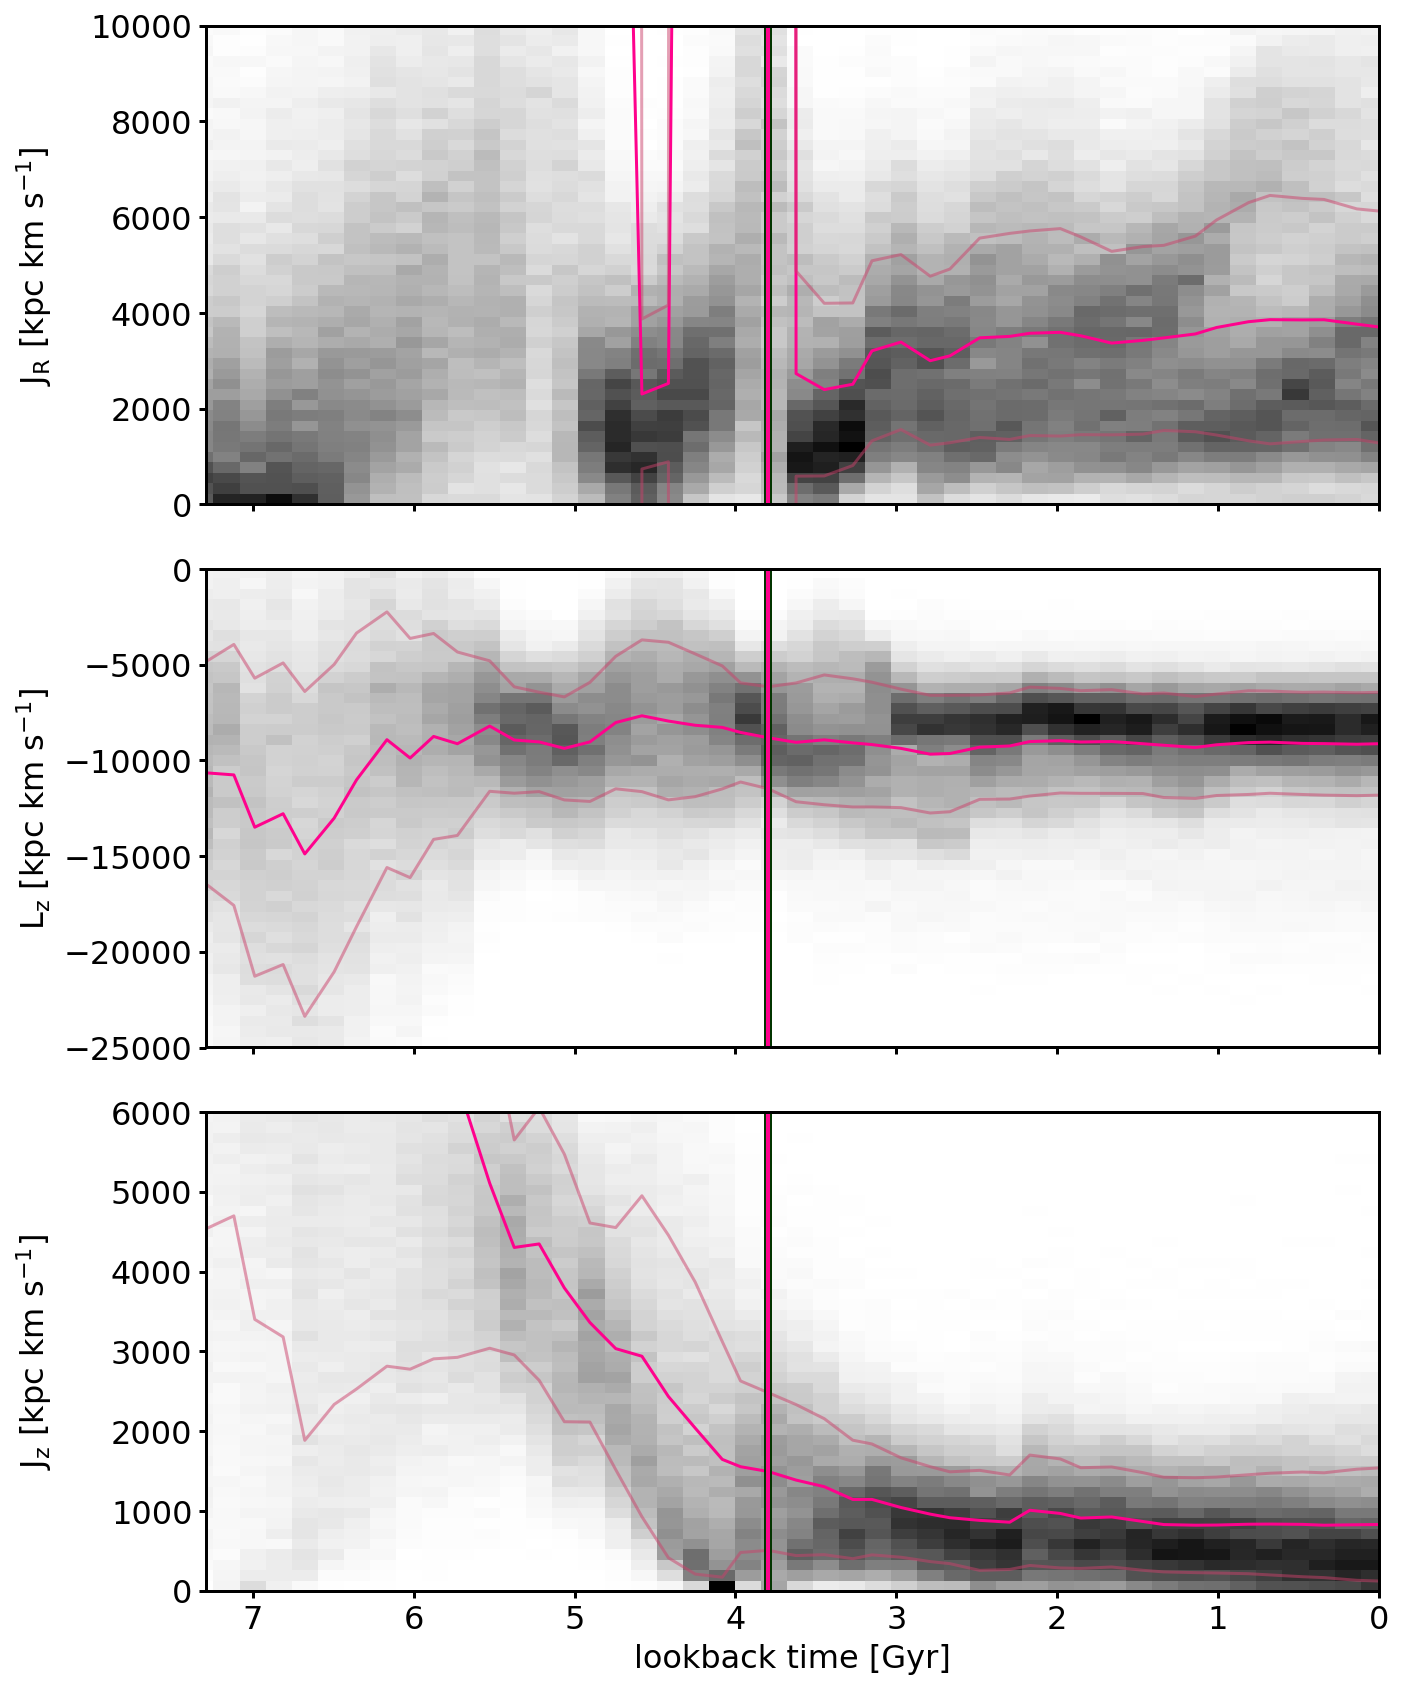

In [17]:
xrange = np.unique(flat_histtime)
x = np.arange(len(flat_histtime))
z = np.polyfit(x,flat_histtime, 1)
p = np.poly1d(z)
time = p(x)

if prognum == 2:
    max_JR = 10000.
    max_LZ = 0.
    min_LZ = -25000.
    max_JZ = 6000.
if prognum == 3:
    max_JR = 15000.
    max_LZ = 10000.
    min_LZ = -15000.
    max_JZ = 6000.
if prognum == 4:
    max_JR = 4000.
    max_LZ = 12000.
    min_LZ = 0.
    max_JZ = 4000.
    
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,12))

# smooth out over hisstime because uneven bins in there mess up hist2d

bins = numsnaps

color = colors[prognum]
color2 = colors2[prognum]
ax[0].hist2d(time[flat_jR <max_JR], flat_jR[flat_jR < max_JR], bins = bins , cmap = plt.cm.binary)

ax[0].plot(xrange[::-1], jR_median, '-',  color = color)
ax[0].plot(xrange[::-1], np.add(jR_median, jR_std), '-', alpha = 0.5,  color = color2)
ax[0].plot(xrange[::-1], np.subtract(jR_median, jR_std), '-', alpha = 0.5, color = color2)
ax[0].set_xlim(np.max(flat_histtime), 0)
ax[0].get_yaxis().set_label_coords(-0.13,0.5)

#cbar = fig.colorbar(H1[3], ax[0])

ax[1].hist2d(time[(flat_lz <max_LZ) * (flat_lz > min_LZ)], flat_lz[(flat_lz <max_LZ) * (flat_lz > min_LZ)], bins = bins, cmap = plt.cm.binary)
ax[1].plot(xrange[::-1], lz_median, '-',  color = color)
ax[1].plot(xrange[::-1], np.add(lz_median, lz_std), '-', alpha = 0.5, color = color2)
ax[1].plot(xrange[::-1], np.subtract(lz_median, lz_std), '-', alpha = 0.5, color = color2)
ax[1].set_xlim(np.max(flat_histtime), 0)
ax[1].get_yaxis().set_label_coords(-0.13,0.5)

ax[2].hist2d(time[flat_jz < max_JZ], flat_jz[flat_jz < max_JZ], bins = bins, cmap = plt.cm.binary)
ax[2].plot(xrange[::-1], jz_median, '-',  color = color)
ax[2].plot(xrange[::-1], np.add(jz_median, jz_std), '-', alpha = 0.5,  color = color2)
ax[2].plot(xrange[::-1], np.subtract(jz_median, jz_std), '-', alpha = 0.5, color = color2)
ax[2].set_xlim(np.max(flat_histtime), 0)
ax[2].get_yaxis().set_label_coords(-0.13,0.5)

ax[0].set_ylabel('J$_\mathrm{R}$ [kpc km s$^{-1}$]')
ax[1].set_ylabel('L$_\mathrm{z}$ [kpc km s$^{-1}$]')
ax[2].set_ylabel('J$_\mathrm{z}$ [kpc km s$^{-1}$]')

ax[2].set_xlabel('lookback time [Gyr]')

ax[0].axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
ax[0].axvline(mergertime1, color = color11, linewidth = 2)
ax[1].axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
ax[1].axvline(mergertime1, color = color11, linewidth = 2)
ax[2].axvline(mergertime1, color = 'xkcd:dark green', linewidth = 4)
ax[2].axvline(mergertime1, color = color11, linewidth = 2)

if prognum == 2:
    pass
else:
    ax[0].axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
    ax[0].axvline(mergertime2, color = color21, linewidth = 2)
    ax[1].axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
    ax[1].axvline(mergertime2, color = color21, linewidth = 2)
    ax[2].axvline(mergertime2, color = 'xkcd:dark green', linewidth = 4)
    ax[2].axvline(mergertime2, color = color21, linewidth = 2)
    
    if prognum == 3:
        pass
    else:
        ax[0].axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
        ax[0].axvline(mergertime3, color = color31, linewidth = 2)
        ax[1].axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
        ax[1].axvline(mergertime3, color = color31, linewidth = 2)
        ax[2].axvline(mergertime3, color = 'xkcd:dark green', linewidth = 4)
        ax[2].axvline(mergertime3, color = color31, linewidth = 2)
        #ax[2].set_xlabel('Snapshot number', fontsize = 20)


fig.tight_layout()
fig.savefig(plotdir + 'actions/right_potential/progenitor{}/action_time_evolution_hist_mean.png'.format(prognum), format = 'png', dpi = 300)
plt.show()